# Using a battery to cut power peaks
There is a limit to the amount of power that can be transmitted by a power grid. My local power grid is at that limit. When in such a situation two things can be done. On the one hand the grid can be upgraded to carry more power. The other way to tackle the problem is to reduce the amount of power the grid has to deliver. The goal of the project given to my team was to cut power peaks for a facility by using a programmable battery in order to free up capacity on the grid. To do this we came up with an control algorithm which we tested by constructing a model of the battery and running it with real hourly power consumption data as input. In this post I will demonstrate how we came up with the first model. In later posts I will show how I've since altered/improved the model. The original model was written in Matlab. In writing this post I'm reacquainting myself with python and learning how to use jupyter.

#### A note on power vs. energy
I like the analogy "power is to energy what velocity is to distance". In this project we are not concerned with "how far" (energy) the power grid can go, but rather by "how fast" (power) it is going. The basic unit of energy is the Joule, denoted 'J' and the basic unit of power is the Watt, denoted with a 'W'. Power is the time derivative of energy, so one Watt is the same as One Joule per second.

#### A note on units
In this project Joules and Watts are rarely (if ever) used in their basic form. Rather we measure power in kilowatts (kW) and energy in kilowatt hours (kWh). Using the kWh to represent energy took some getting used to. Consuming one kilowatt of power for the duration of one hour results in the total energy consumption for the hour being one kilowatt hour. Looking at the units, things become a bit more clear. Multiplying a power with the duration of the power means that time "cancels out", yielding only energy in the same way as multiplying a velocity with its duration gives a distance.

## The raw data
The power consumption data we were given consisted of hourly average values in kW. The data stretched back for as long as the facilites had been around. Both were quite new, so we had about a couple of years worth. Below is shown a typical month of power usage for one of the facilities.




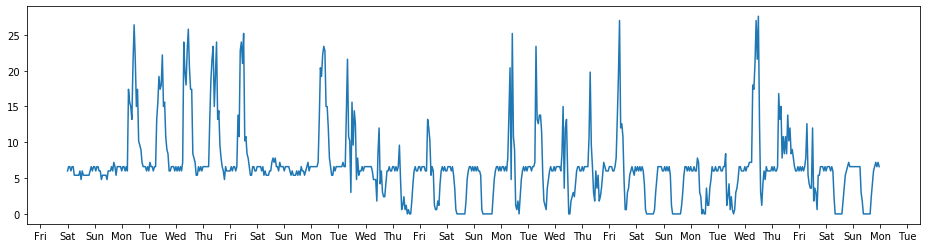

In [2]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import matplotlib.dates as mdates
import datetime
days = [datetime.datetime(2018, 9, 1) + datetime.timedelta(hours = x) for x in range(len(loadvec))]
DATAFILE = "../data/Sep2018.txt"
loadvec = np.loadtxt(DATAFILE).reshape(-1,1)
fig, ax = plt.subplots(figsize = (16,4))
_ = ax.plot(days, loadvec)
weekday = mdates.DayLocator()  # every month
years_fmt = mdates.DateFormatter('%a')
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(weekday)

We get some spikes during the weekdays and not much above base load during the weekends. An interesting thing to note is that during this month solar panels were installed during the second week. This had the effect of sometimes reducing the power drawn from the grid to 0. It also helps in reducing the size of the peaks when the day is not cloudy.

In [ ]:
sys.path.append("../src")
import battery_hour_data